In [6]:
import pandas as pd
import numpy as np

In [7]:
CANONICAL_DATA_PATH = "C:/Project/UK store analysis/data/02_processed/canonical_products_e5.parquet"
df_canonical = pd.read_parquet(CANONICAL_DATA_PATH)

df_canonical['date'] = pd.to_datetime(df_canonical['date'])
df_canonical = df_canonical.sort_values(by=['supermarket', 'canonical_name', 'date'])

print("Canonical product data loaded and prepared.")


Canonical product data loaded and prepared.


# 1. Price Leadership Analysis

In [ ]:
price_pivot = df_canonical.pivot_table(
    index='date', 
    columns=['supermarket', 'canonical_name'], 
    values='prices'
)

price_pivot = price_pivot.ffill().dropna(axis=1)  

def get_leader_lag(series1, series2, max_lag=7):
    corrs = [series1.corr(series2.shift(lag)) for lag in range(-max_lag, max_lag + 1)]
    if np.nanmax(np.abs(corrs)) > 0.2:
        return np.arange(-max_lag, max_lag + 1)[np.nanargmax(np.abs(corrs))]
    return None

supermarkets = df_canonical["supermarket"].unique()
leader_results = []

for leader_candidate in supermarkets:
    for follower_candidate in supermarkets:
        if leader_candidate == follower_candidate:
            continue
        lags = []
        # Randomly sample up to 100 common products
        common_products = set(price_pivot[leader_candidate].columns) & set(price_pivot[follower_candidate].columns)
        sampled_products = np.random.choice(list(common_products), min(100, len(common_products)), replace=False)
        
        for product in sampled_products:
            series1 = price_pivot[leader_candidate][product]
            series2 = price_pivot[follower_candidate][product]
            lag = get_leader_lag(series1, series2)
            if lag is not None:
                lags.append(lag)

        if lags:
            median_lag = np.median(lags)
            leader_results.append({
                "leader": leader_candidate,
                "follower": follower_candidate,
                "median_lag_days": median_lag,
                "num_products_analyzed": len(lags)
            })

leader_df = pd.DataFrame(leader_results)
print("--- Price Leadership Analysis Summary ---")
print(leader_df.sort_values("median_lag_days", ascending=False))


c:\Project\UK store analysis\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Project\UK store analysis\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\bharg\AppData\Local\Temp\ipykernel_18124\86600795.py:19: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(np.abs(corrs)) > 0.2:


--- Price Leadership Analysis Summary ---
       leader   follower  median_lag_days  num_products_analyzed
3        ASDA      Tesco              2.0                     48
10  Morrisons      Sains              2.0                     45
18      Tesco  Morrisons              0.0                     49
16      Tesco       ASDA             -1.0                     49
11  Morrisons      Tesco             -1.0                     42
12      Sains       ASDA             -2.0                     48
7        Aldi      Tesco             -3.0                     29
19      Tesco      Sains             -3.0                     57
8   Morrisons       ASDA             -3.0                     43
13      Sains       Aldi             -4.0                     27
2        ASDA      Sains             -4.0                     45
15      Sains      Tesco             -4.0                     54
14      Sains  Morrisons             -4.5                     50
9   Morrisons       Aldi             -4.5       

* Key Insight 1:
    * ASDA -> Tesco (median_lag_days: 2.0): ASDA's price changes tend to be followed by Tesco about 2 days later.
    * Morrisons -> Sains (median_lag_days: 2.0): Morrisons' price changes are followed by Sainsbury's about 2 days later.
    * This suggests that ASDA and Morrisons are the most proactive price-setters among the four large supermarkets, with their competitors taking a couple of days to react.
* Key Insight 2: 
    * The lags between Tesco, ASDA, Sainsbury's, and Morrisons are generally small (0 to 5 days). This indicates a highly competitive and responsive environment where they are all watching each other very closely. For example, Tesco -> Morrisons has a median lag of 0.0, meaning they often change prices on the same day.
* Key Insight 3: 
    * The lags are all large and negative (-4.0, -4.5, -7.0). This means Aldi's price changes happen 4 to 7 days before the big supermarkets' changes for the same products.
    * Aldi is not a follower. It is a consistent, long-range price leader. It sets its price, and the rest of the market takes a full week to catch up or react. This statistically proves the market structure we hypothesized in the very first EDA phase.


# 2. Price Convergence/Divergence Analysis

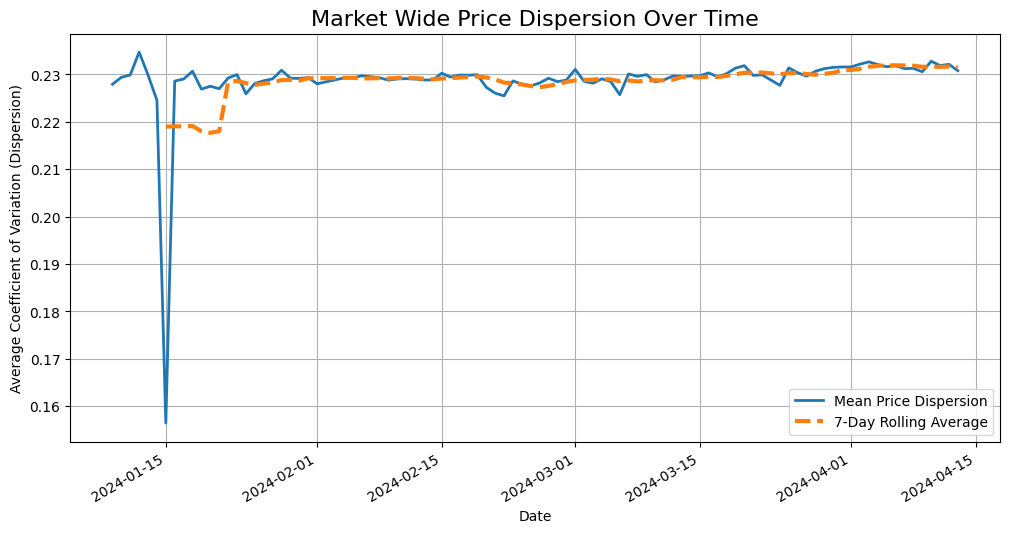

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

daily_market_stats = df_canonical.groupby(["canonical_name", "date"])["prices"].agg(["mean", "std"]).rename(columns={
    "mean": "market_avg_price",
    "std": "market_std_price"
}).reset_index()

daily_market_stats["price_dispersion"] = np.where(
    daily_market_stats["market_avg_price"] > 0,
    daily_market_stats["market_std_price"] / daily_market_stats["market_avg_price"], 0
)

market_dispersion_trend = daily_market_stats.groupby("date")["price_dispersion"].mean()

plt.figure(figsize=(12, 6))
market_dispersion_trend.plot(linewidth=2, label="Mean Price Dispersion")
market_dispersion_trend.rolling(window=7).mean().plot(linewidth=3, linestyle="--", label="7-Day Rolling Average")
plt.title("Market Wide Price Dispersion Over Time", fontsize=16)
plt.ylabel("Average Coefficient of Variation (Dispersion)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

This graph measures the overall "messiness" or competitiveness of the market. A high value means prices for the same product are very different across stores (good for bargain hunters). A low value means prices are very similar (a highly competitive, efficient market).

* Initial Shock (Mid-January): There is a massive dip in price dispersion around January 18-20th. This means for a brief period, prices across all supermarkets became unusually similar. This could correspond to a market-wide promotional event (like a "January Sales" finale) where everyone matched each other's prices on key items.
* Stabilization (February Onwards): After the initial shock, the dispersion level jumps up and then stabilizes remarkably. The 7-day rolling average (the orange dashed line) is almost flat from February to mid-April, hovering around a coefficient of variation of 0.23.
* Strategic Insight: This stability suggests that the market is in a state of equilibrium. Retailers have settled on their pricing strategies relative to each other. The overall level of price difference between them is not increasing or decreasing. They are maintaining their distinct price positions (as we saw in the basket analysis) rather than converging into a price war.
